#Exploratory Data Analysis on a Open-Source dataset

Here, I have performed an Exploratory Data Analysis on a data(from kaggle-student performance). I have tried to uncover the patterns,understand correlation between student attributes and their acdemic scores and some trends in the data.

Load the Dataset

In [0]:
# PySpark and plotting libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, when, count
import pandas as pd
import matplotlib.pyplot as plt

# Create Spark session (automatically available in Databricks)
spark = SparkSession.builder.getOrCreate()

# Load CSV into DataFrame
file_path = "/Volumes/databricks_for_practice/default/data/"
df = spark.read.option("header", True).option("inferSchema", True).csv(file_path)

# Preview the data
df.show(5)

+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|gender|race/ethnicity|parental level of education|       lunch|test preparation course|math score|reading score|writing score|
+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|female|       group B|          bachelor's degree|    standard|                   none|        72|           72|           74|
|female|       group C|               some college|    standard|              completed|        69|           90|           88|
|female|       group B|            master's degree|    standard|                   none|        90|           95|           93|
|  male|       group A|         associate's degree|free/reduced|                   none|        47|           57|           44|
|  male|       group C|               some college|    standard|                   none|        76|     

Schema of the dataset

In [0]:
# Schema
df.printSchema()

# Total number of rows
print("Total Rows:", df.count())

# Summary statistics
df.describe().show()

root
 |-- gender: string (nullable = true)
 |-- race/ethnicity: string (nullable = true)
 |-- parental level of education: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- test preparation course: string (nullable = true)
 |-- math score: integer (nullable = true)
 |-- reading score: integer (nullable = true)
 |-- writing score: integer (nullable = true)

Total Rows: 1000
+-------+------+--------------+---------------------------+------------+-----------------------+------------------+-----------------+------------------+
|summary|gender|race/ethnicity|parental level of education|       lunch|test preparation course|        math score|    reading score|     writing score|
+-------+------+--------------+---------------------------+------------+-----------------------+------------------+-----------------+------------------+
|  count|  1000|          1000|                       1000|        1000|                   1000|              1000|             1000|              1

Finding the missing value

In [0]:
# Count nulls in each column
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+
|gender|race/ethnicity|parental level of education|lunch|test preparation course|math score|reading score|writing score|
+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+
|     0|             0|                          0|    0|                      0|         0|            0|            0|
+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+



Finding the Unique values

In [0]:
for column in df.columns:
    print(f"{column}: {df.select(column).distinct().count()} unique values")

gender: 2 unique values
race/ethnicity: 5 unique values
parental level of education: 6 unique values
lunch: 2 unique values
test preparation course: 2 unique values
math score: 81 unique values
reading score: 72 unique values
writing score: 77 unique values


Score distribution analysis

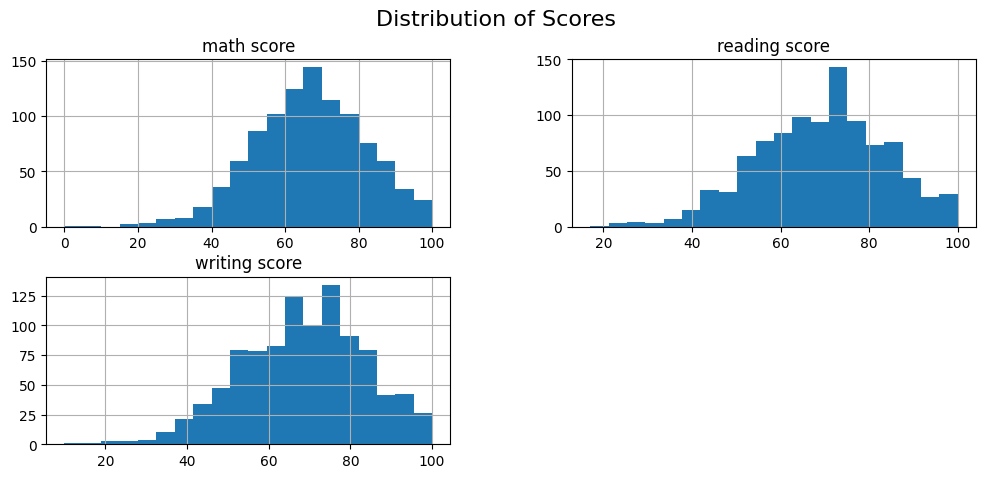

In [0]:
# Convert to pandas for easy plotting
pdf = df.select("math score", "reading score", "writing score").toPandas()

# Plot histograms
pdf.hist(figsize=(12, 5), bins=20)
plt.suptitle("Distribution of Scores", fontsize=16)
plt.show()

Average scored grouped by gender

In [0]:
# Average score per gender
df.groupBy("gender").agg(
    mean("math score").alias("Avg Math"),
    mean("reading score").alias("Avg Reading"),
    mean("writing score").alias("Avg Writing")
).show()

+------+------------------+-----------------+-----------------+
|gender|          Avg Math|      Avg Reading|      Avg Writing|
+------+------------------+-----------------+-----------------+
|  male| 68.72821576763485|65.47302904564316|63.31120331950208|
|female|63.633204633204635|72.60810810810811|72.46718146718146|
+------+------------------+-----------------+-----------------+



Visualisation:
Gender wise average score

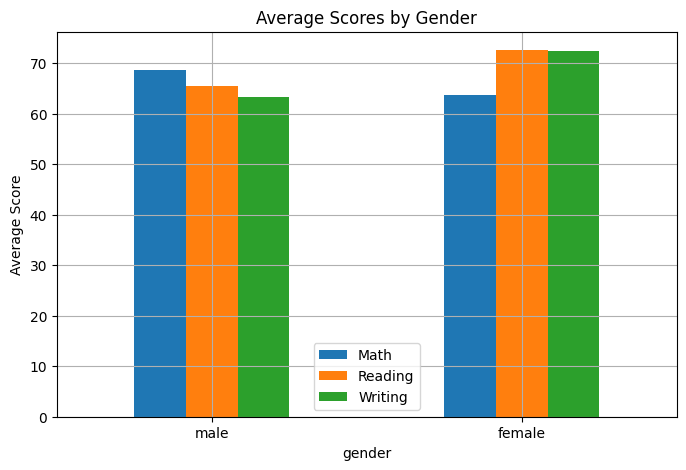

In [0]:
# Visualization (using Pandas + Matplotlib)
gender_scores = df.groupBy("gender").agg(
    mean("math score").alias("Math"),
    mean("reading score").alias("Reading"),
    mean("writing score").alias("Writing")
).toPandas().set_index("gender")

gender_scores.plot(kind="bar", figsize=(8, 5))
plt.title("Average Scores by Gender")
plt.ylabel("Average Score")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

Comparing score based on parental education

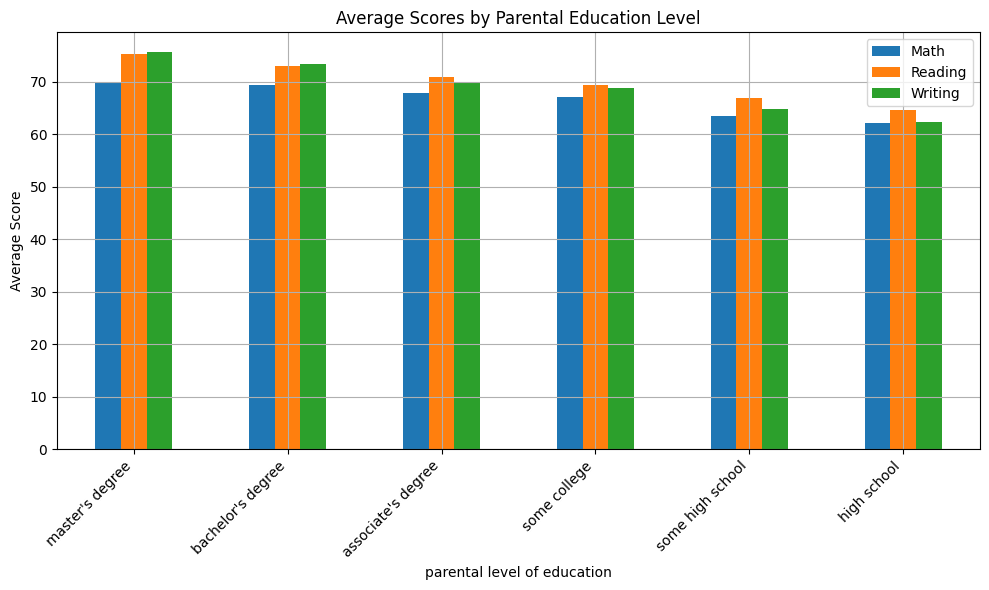

In [0]:
parent_edu_scores = df.groupBy("parental level of education").agg(
    mean("math score").alias("Math"),
    mean("reading score").alias("Reading"),
    mean("writing score").alias("Writing")
).toPandas().set_index("parental level of education").sort_values("Math", ascending=False)

parent_edu_scores.plot(kind="bar", figsize=(10, 6))
plt.title("Average Scores by Parental Education Level")
plt.ylabel("Average Score")
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()

Effect of test preparation course

In [0]:
df.groupBy("test preparation course").agg(
    mean("math score").alias("Math"),
    mean("reading score").alias("Reading"),
    mean("writing score").alias("Writing")
).show()

+-----------------------+-----------------+-----------------+-----------------+
|test preparation course|             Math|          Reading|          Writing|
+-----------------------+-----------------+-----------------+-----------------+
|                   none| 64.0778816199377|66.53426791277259|64.50467289719626|
|              completed|69.69553072625699|73.89385474860335|74.41899441340782|
+-----------------------+-----------------+-----------------+-----------------+



Correlation analysis

               math score  reading score  writing score
math score       1.000000       0.817580       0.802642
reading score    0.817580       1.000000       0.954598
writing score    0.802642       0.954598       1.000000


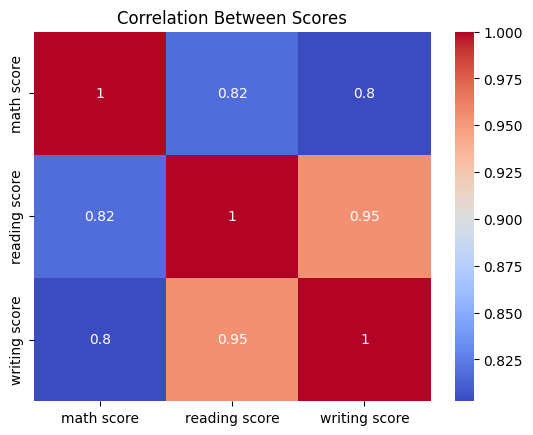

In [0]:
# Correlation between scores
pdf = df.select("math score", "reading score", "writing score").toPandas()
correlation = pdf.corr()
print(correlation)

# Heatmap
import seaborn as sns
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Between Scores")
plt.show()

##Conclusion
Girls tend to excel in language-based subjects, achieving higher averages in both reading and writing, while boys show a modest advantage in mathematics.

Participation in test preparation programs is linked to better academic outcomes, with noticeable improvements across all subject areas.

Students whose parents have attained higher education levels generally perform better, indicating the influence of parental education on academic success.

There is a notable connection between reading and writing scores, suggesting that strength in one often supports achievement in the other.